<a href="https://colab.research.google.com/github/arashfahim/Stochastic_Control_FSU/blob/arash/Discrete_time_DPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/arashfahim/Stochastic_Control_FSU

Cloning into 'Stochastic_Control_FSU'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 72 (delta 36), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (72/72), 441.31 KiB | 1.71 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [2]:
! ls -l

total 8
drwxr-xr-x 1 root root 4096 Oct  6 13:25 sample_data
drwxr-xr-x 4 root root 4096 Oct 10 14:25 Stochastic_Control_FSU


In [3]:
path = r'/content/Stochastic_Control_FSU/arashfahim/Stochastic_Control_FSU/'

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The goal of this notebook is to implement a one-step dynamic programming principle, DPP, for a stochastic control problem.

The stochastic control problem is given by

$\inf_{u_0,...u_{T-1}}\mathbb{E}\bigg[\sum_{t=0}^{T-1}C(t,X^u_t,u_t)+g(X^u_T)\bigg]$




The DPP is given by

$\begin{cases}
V(t,x)=\inf_{u\in\mathbb{R}^d}\mathbb{E}[C(t,x,u)+V(t+1,X^u_{t+1})]\\
V(T,x)=g(x)
\end{cases}$

with $X^u_{t+1}=x+\mu(t,x,u)+\sigma(t,x,u)\xi_{t+1}$

# Step 1. Creation of optimization module

We need to solve the above one-step optimization problem.

Input: $\phi(x,u,\xi)$ and $c(x,u)$

Optimize: $\inf_u\mathbb{E}[c(x,u)+\phi(x,u,\xi)]$

Output: $u^*(x)\in\textrm{argmin}\mathbb{E}[c(x,u)+\phi(x,u,\xi)]$



---

It is important to make sure the input and output are functions and not just data points.

## Step 1.1. Expected value

To evaluate $\mathbb{E}[c(t,x,u)+\phi(x,\xi)]$ in Step 1, we need to create a module that evaluate expected value using a set of samples of $\xi$.
Such module must evaluate the expected value a a function of $x$. To do this, we use the following two wellknown theorems about conditional expectation


  1) If $X$ and $\xi$ are independent, then $\mathbb{E}[\phi(X,\xi)|X]= \Phi(X)$, where $\Phi(x)=\mathbb{E}[\phi(x,\xi)]$.

  2) $\mathbb{E}[Y|X]=f(X)$, where $f(x)$ is the minimizer of $\mathbb{E}[(Y-f(X))^2]$.



## Neural network approximation of conditional expectation

$\inf_{\theta}\mathbb{E}[(Y-\phi(X;\theta))^2]$

and $\phi(x;\theta)$ is a neural network with parameter $\theta$.

In [5]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from time import strftime, localtime
import torch.optim as optim #import optimizer
# import torch.optim.lr_scheduler as lr_scheduler

M =10000# number of samples
X = torch.normal(0., 1., size=(M,1))# samples for X~N(0,1)
Y = torch.exp(-X)+torch.exp(X)*torch.normal(0., 1., size=(M,1))# samples for Y=e^{-x}+e^{x}N(0,1)
# X.shape
T=1# terminal horizon
N = 10 # of time steps
Dt= torch.Tensor([T/N])# time step size

In [6]:
def loss_fun(y,x,model):# y :samples for $Y$, x: samples for x, model: nn
  return torch.mean(torch.pow(model(x)-y,2))


In [7]:
# create time stamp to save the result
stamp = strftime('%Y-%m-%d %H:%M:%S', localtime())
print(str(stamp))

2023-10-10 14:26:06


## Function for conditional expectation

## Test examples using neural networks

Let's write a module that takes samples of $(X,Y)$ and returns $\mathbb{E}[Y|X=x]$

Example: $X$ standard normal and $Y=e^{-X}+e^X\xi$ where $\xi$ is standard normal independent of $X$. We know $\mathbb{E}[Y|X]=e^{-X}$.

In [8]:
#hyperparameters for learning
lr = 1e-3
num_epochs = 10000
torch.set_printoptions(precision=10)
loss_epoch = torch.zeros(num_epochs)

In [9]:
'''conditional expectation of X[1,:] given X[0,:] in for of trained model'''
def cond_expect(data, model):
  optimizer = optim.Adam(model.parameters(), lr)
  L_ = torch.Tensor([-2.0])
  loss = torch.Tensor([2.0])
  epoch=0
  while (torch.abs(L_-loss)>1e-4) & (epoch <= num_epochs):# epoch in range(num_epochs):
    optimizer.zero_grad()
    loss=loss_fun(data[:,1].unsqueeze(1),data[:,0].unsqueeze(1),model)# Y=data[:,1], X=data[:,0]
    loss.backward()
    optimizer.step()
    loss_epoch[epoch] = loss
    if epoch>0:
      L_ = loss_epoch[epoch-1]
    if (epoch % 100==0):
      print("At epoch {} the mean error is {}.".format(epoch,loss.detach()))
    epoch += 1


In [10]:
# increase neurons
model3= torch.nn.Sequential(
    torch.nn.Linear(1, 16),
    torch.nn.Tanh(),
    # torch.nn.Sigmoid(),
    # torch.nn.ReLU(),
    torch.nn.Linear(16,1)
)

In [11]:
data = torch.cat((X,Y),dim=1)
cond_expect(data,model3)


At epoch 0 the mean error is 15.033049583435059.
At epoch 100 the mean error is 11.982816696166992.
At epoch 200 the mean error is 10.092251777648926.
At epoch 300 the mean error is 9.269640922546387.
At epoch 400 the mean error is 8.954851150512695.
At epoch 500 the mean error is 8.761733055114746.
At epoch 600 the mean error is 8.601302146911621.
At epoch 700 the mean error is 8.460375785827637.
At epoch 800 the mean error is 8.336241722106934.
At epoch 900 the mean error is 8.22555923461914.
At epoch 1000 the mean error is 8.124606132507324.
At epoch 1100 the mean error is 8.030591011047363.
At epoch 1200 the mean error is 7.941854476928711.
At epoch 1300 the mean error is 7.8576788902282715.
At epoch 1400 the mean error is 7.777978897094727.
At epoch 1500 the mean error is 7.702976703643799.
At epoch 1600 the mean error is 7.632914066314697.
At epoch 1700 the mean error is 7.567903995513916.
At epoch 1800 the mean error is 7.5078959465026855.
At epoch 1900 the mean error is 7.45270

In [12]:
Z = torch.normal(0., 1., size=(M,1))
W = torch.exp(-Z)+torch.exp(Z)*torch.normal(0., 1., size=(M,1))
torch.set_printoptions(precision=10)
print("Test on new data: MSE = {}".format(loss_fun(W,Z,model3)))

Test on new data: MSE = 8.559926986694336


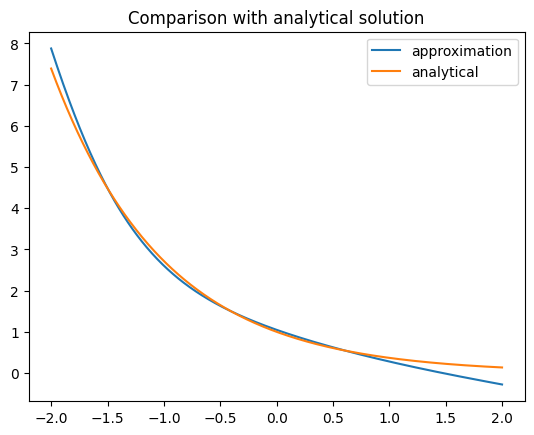

In [13]:
xx = torch.linspace(-2,2,600)
yy = model3(xx.unsqueeze(1))
plt.plot(xx.detach().numpy(),yy.detach().numpy(), label='approximation');
plt.plot(xx.detach().numpy(),np.exp(-xx.detach().numpy()), label='analytical');
plt.title("Comparison with analytical solution");
plt.legend();
plt.savefig(path+'test for model3'+stamp+'.png');

### **Evaluation of conditional expectation using deep learning is cool and all, but it is slow and causes some issue while training the neural net for the control. Therefore, we have to change our approach.**

In [14]:
for p in model3.parameters():
  print(p)

Parameter containing:
tensor([[-0.1203031316],
        [ 0.9123863578],
        [-1.1486060619],
        [-0.1214548349],
        [ 0.6299881339],
        [-1.0704641342],
        [-0.1205072105],
        [-0.1256858706],
        [-0.1373539716],
        [-0.1466233283],
        [ 1.0024234056],
        [-0.1496175379],
        [ 0.8975618482],
        [-0.1227232665],
        [ 0.1269454062],
        [-0.1307323426]], requires_grad=True)
Parameter containing:
tensor([ 1.9447231293,  2.0259888172, -2.7934408188,  1.8558006287,
        -0.0701921806, -2.5538697243,  1.9441053867,  1.9437050819,
         1.3279644251,  1.0968809128,  2.3412177563,  1.0864057541,
         1.9701118469,  1.9992554188, -1.5432823896,  1.4135186672],
       requires_grad=True)
Parameter containing:
tensor([[ 0.8351651430, -1.5807929039,  1.8796470165,  0.6270911098,
         -0.5762971640,  2.4937074184,  0.8392764926,  1.6174060106,
          1.4081963301,  1.0599458218, -1.6234918833,  0.7217177749,
      

## Write one-step DPP as

$V(t,x)=\inf_{u(x)}C(t,x,u(x))+\mathbb{E}^{B}[V(t+1,X^u_{t+1})]$

Formulate the loss function as

$\inf_{\theta}\mathbb{E}^{X_t,B}\bigg[C(t,X_t,u(X_t;\theta))+V\Big(t+1,X_{t}+\mu\big(t,X_{t},u(X_t;\theta)\big)\Delta t+\sigma\big(t,X_{t},u(X_t;\theta)\big)\Delta B_{t+1})\Big)\bigg]$

The empirical loss is given base on a sample of $X_t$, $\{x^j\}$ and $N(0,1)$, $\{\xi^j\}$, independently.

$\inf_{\theta}\sum_{j}\bigg[C(t,x^j,u(x^j;\theta))+V\Big(t+1,x^j+\mu\big(t,x^j,u(x^j;\theta)\big)\Delta t+\sigma\big(t,x^j,u(x^j;\theta)\big)\sqrt{\Delta t} \xi^j)\Big)\bigg]$


# Multistep DPP

## At $t=T-\Delta t$

In [66]:
# increase neurons
modelu= torch.nn.Sequential(
    torch.nn.Linear(1, 16),
    torch.nn.Tanh(),
    # torch.nn.Linear(8, 8),
    # torch.nn.ReLU(),
    torch.nn.Linear(16,1)
)

In [102]:
class cost:
  def __init__(self,flag):
    self.flag = flag
  def cost(self,x,*args):
    if self.flag == 'T':
      return torch.Tensor([0.5])*torch.pow(x,2)-x
    else:
      u=args[0]
      return torch.Tensor([0.5])*torch.pow(x,2) + torch.Tensor([0.5])*torch.pow(u,2)
# goal: to add the term E[V(t+1, X^u_{t+1})|X_t=x] inside the cost function for t<T.

In [103]:
g = cost('T')
c = cost('')

In [104]:
x = torch.Tensor([1.0])
c.cost(x,modelu(x)),g.cost(x)

(tensor([0.5000542402], grad_fn=<AddBackward0>), tensor([-0.5000000000]))

In [105]:
xi = torch.normal(0., 1., size=(M,1))
def update(x,u):
  return x + (-x+u)*Dt + torch.sqrt(Dt)*xi

### Last step with $g(X^u_{T})$

In [106]:
X = torch.normal(0., 1., size=(M,1))# samples for X~N(0,1)

In [107]:
# # increase neurons
# modelexcost= torch.nn.Sequential(
#     torch.nn.Linear(1, 16),
#     torch.nn.Tanh(),
#     # torch.nn.Linear(8, 8),
#     # torch.nn.ReLU(),
#     torch.nn.Linear(16,1)
# )

In [108]:
# for p in modelu.parameters():
#   p.requires_grad = False
# Y = g.cost(update(X,modelu(X)))
# data = torch.cat((X,Y),dim=1)
# cond_expect(data,modelexcost)


In [109]:
c.cost(X,modelu(X))+ g.cost(update(X,modelu(X)))

tensor([[0.3524504900],
        [0.4692361355],
        [3.9922103882],
        ...,
        [2.7156906128],
        [0.9663087130],
        [6.5463485718]], grad_fn=<AddBackward0>)

In [110]:
num_epochs = 100
optimizer1 = optim.Adam(modelu.parameters(), lr)
L_ = torch.Tensor([-2.0])
loss = torch.Tensor([2.0])
loss_epoch = []
epoch=0
while (torch.abs(L_-loss)>1e-6) & (epoch <= num_epochs):# epoch in range(num_epochs):
  optimizer1.zero_grad()
  loss=torch.mean(c.cost(X,modelu(X))+ g.cost(update(X,modelu(X))))#
  loss.backward()
  optimizer1.step()
  loss_epoch[epoch] = loss
  if epoch>0:
    L_ = loss_epoch[epoch-1]
  if (epoch % 10==0):
    print("At epoch {} the mean error is {}.".format(epoch,loss.detach()))
  epoch += 1

At epoch 0 the mean error is 0.9484808444976807.
At epoch 10 the mean error is 0.9483281970024109.
At epoch 20 the mean error is 0.9482594728469849.
At epoch 30 the mean error is 0.9482182860374451.
At epoch 40 the mean error is 0.9481935501098633.
At epoch 50 the mean error is 0.9481764435768127.


In [111]:
Z = torch.normal(0., 1., size=(M,1))
torch.set_printoptions(precision=10)
print("Test on new data: MSE = {}".format(torch.mean(c.cost(Z,modelu(Z))+ g.cost(update(Z,modelu(Z))))))

Test on new data: MSE = 0.9492029547691345


In [112]:
def test_update(x,u):
  return x + (-x+modelu(x))*Dt + torch.mean(torch.sqrt(Dt)*torch.normal(0., 1., size=[x.shape[0],M]))
def V(x, u):
  return c.cost(x,u)+torch.mean(g.cost(test_update(x,u)))#c.cost(x,u)+torch.mean(g.cost(test_update(x,u))),

In [121]:
x = torch.Tensor([1.0]).unsqueeze(1)
V(x,modelu(x)).squeeze(1)

tensor([0.0046203732], grad_fn=<SqueezeBackward1>)

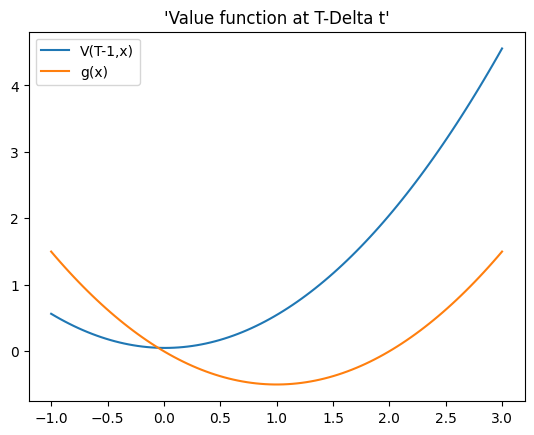

In [119]:
xx = torch.linspace(-1.0,3.0,100).unsqueeze(1)
yy = V(xx,modelu(xx))
zz = g.cost(xx)
plt.plot(xx.squeeze(1).detach().numpy(),yy.squeeze(1).detach().numpy(),label='V(T-1,x)');
plt.plot(xx.squeeze(1).detach().numpy(),zz.squeeze(1).detach().numpy(),label='g(x)');
plt.title("'Value function at T-Delta t'");
plt.legend();
plt.savefig(path+'test for value'+stamp+'.png');

### Write the value function into a separate function from training

In [29]:
def V(x, model):
  u = model(x).clone().detach()
  return c.cost(x,u)+torch.mean(g.cost(test_update(x,u)))#c.cost(x,u)+torch.mean(g.cost(test_update(x,u))),

In [35]:
c.cost(xx.unsqueeze(1),modelu(xx.unsqueeze(1))).shape

torch.Size([100, 1])

In [80]:
xx = torch.linspace(0.0,1.0,100).unsqueeze(1)
xx.shape

torch.Size([100, 1])

In [92]:
yy = xx + (-xx+modelu(xx))*Dt + torch.mean(torch.sqrt(Dt)*torch.normal(0., 1., size=[xx.shape[0],M]))
yy.shape

torch.Size([100, 1])

In [158]:
class one_step:
  def __init__(self,next_step,flag):
    self.flag = flag
    self.M = 10000
    self.temp_term = next_step
    # increase neurons
    self.modelu= torch.nn.Sequential(
        torch.nn.Linear(1, 16),
        torch.nn.Tanh(),
        # torch.nn.Linear(8, 8),
        # torch.nn.ReLU(),
        torch.nn.Linear(16,1)
    )
    self.X = torch.normal(0., 1., size=(M,1))#traning set
    self.u = self.modelu(x)
  def update(self,x):
    return x + (-x+self.u)*Dt + torch.sqrt(Dt)*torch.normal(0., 1., size=[x.shape[0],M])#M global var num of samples
  def terminal(self,x):
    return self.temp_term.value(x)#torch.Tensor([0.5])*torch.pow(x,2)-x
  def cost(self,x):#take a [N,1] tensor
      return torch.Tensor([0.5])*torch.pow(x,2) + torch.Tensor([0.5])*torch.pow(self.modelu(x),2)
  def value(self,x):
    if self.flag == 'T':
      return torch.Tensor([0.5])*torch.pow(x,2)-x
    else:
      return self.cost(x) + torch.mean(self.terminal(self.update(x,self.u)))

  def train_u(self):
    self.loss_epoch = []
    num_epochs = 100
    lr = 1e-2
    optimizer1 = optim.Adam(self.modelu.parameters(), lr)
    L_ = torch.Tensor([-2.0])
    loss = torch.Tensor([2.0])
    epoch=0
    while (torch.abs(L_-loss)>1e-6) & (epoch <= num_epochs):# epoch in range(num_epochs):
      optimizer1.zero_grad()
      loss= self.value(self.X)#self.cost(self.X,self.modelu(X))+ torch.mean(self.terminal(update(self.X,self.modelu(X))))#
      loss.backward()
      optimizer1.step()
      self.loss_epoch.append(loss)
      if epoch>0:
        L_ = loss_epoch[epoch-1]
      if (epoch % 10==0):
        print("At epoch {} the mean error is {}.".format(epoch,loss.detach()))
      epoch += 1

In [154]:
g = one_step('','T')
g.value(xx)

tensor([[ 1.5000000000],
        [ 1.4200081825],
        [ 1.3416488171],
        [ 1.2649219036],
        [ 1.1898275614],
        [ 1.1163656712],
        [ 1.0445362329],
        [ 0.9743393660],
        [ 0.9057749510],
        [ 0.8388429880],
        [ 0.7735435367],
        [ 0.7098765969],
        [ 0.6478420496],
        [ 0.5874400735],
        [ 0.5286705494],
        [ 0.4715335369],
        [ 0.4160289764],
        [ 0.3621568978],
        [ 0.3099173605],
        [ 0.2593102753],
        [ 0.2103356868],
        [ 0.1629935801],
        [ 0.1172839552],
        [ 0.0732068121],
        [ 0.0307621676],
        [-0.0100499941],
        [-0.0492296703],
        [-0.0867768601],
        [-0.1226915643],
        [-0.1569737792],
        [-0.1896235049],
        [-0.2206407487],
        [-0.2500255108],
        [-0.2777777910],
        [-0.3038975596],
        [-0.3283848763],
        [-0.3512396514],
        [-0.3724619746],
        [-0.3920518160],
        [-0.4100091755],


In [159]:
v.train_u()

TypeError: ignored

In [155]:
v = one_step(g,'')

In [156]:
v.terminal(v.X)

tensor([[-0.3247018456],
        [-0.3095855713],
        [ 0.7207034826],
        ...,
        [ 0.8146924973],
        [-0.3548240066],
        [-0.2202193737]])

In [157]:
v.update(v.X)

tensor([[ 0.5478790998,  0.6939641833,  0.4680127800,  ...,
         -0.0284706056,  0.6418790817,  0.0946417749],
        [ 1.4765957594,  0.9914736748,  2.1525578499,  ...,
          1.4823369980,  1.1247969866,  1.3581933975],
        [-0.8065315485, -0.6742634177, -0.6797224879,  ...,
         -0.3829922974, -0.0454217196, -0.6900122166],
        ...,
        [-0.2965789437, -0.3148458302, -0.2024536431,  ...,
         -0.0854458213, -0.6522000432, -0.8208084106],
        [ 0.7445594072,  0.6381737590,  0.5949888825,  ...,
          0.0239039361,  0.6754356623,  0.1126285195],
        [ 1.8171387911,  1.7921034098,  1.9055365324,  ...,
          1.5356978178,  1.7326024771,  1.8199756145]], grad_fn=<AddBackward0>)

# Scratch coding

##########################################

In [ ]:
#hyperparameters for learning
lr = 1e-3
num_epochs = 1000
torch.set_printoptions(precision=10)
loss_epoch = torch.zeros(num_epochs)
optimizer = optim.Adam(modelu.parameters(), lr)
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1e-1, end_factor=1e-5, total_iters=100)

In [ ]:
'''conditional expectation of X[1,:] given X[0,:] in for of trained model'''
def oneStep(data, model):
  optimizer = optim.Adam(model.parameters(), lr)
  L_ = torch.Tensor([-2.0])
  loss = torch.Tensor([2.0])
  epoch=0
  while (torch.abs(L_-loss)>1e-4) & (epoch <= num_epochs):# epoch in range(num_epochs):
    optimizer.zero_grad()
    loss=loss_fun(data[:,1].unsqueeze(1),data[:,0].unsqueeze(1),model)# Y=data[:,1], X=data[:,0]
    loss.backward()
    optimizer.step()
    loss_epoch[epoch] = loss
    if epoch>0:
      L_ = loss_epoch[epoch-1]
    if (epoch % 100==0):
      print("At epoch {} the mean error is {}.".format(epoch,loss.detach()))
    epoch += 1


In [ ]:
#saving the model
torch.save(model1, path+"model1_"+str(stamp)+".pt")

In [ ]:
# write loss into a daraframe
df_loss = pd.DataFrame([range(num_epochs), loss_epoch.detach().numpy()]).T
df_loss.columns = ['Epoch','Loss']
df_loss['Epoch'] = df_loss['Epoch'].astype('int64')
df_loss.to_csv(path+"run_model1_"+str(stamp)+".csv",sep=",")

In [ ]:
# testing
Z = torch.normal(0., 1., size=(M,1))
W = torch.exp(-Z)+torch.exp(Z)*torch.normal(0., 1., size=(M,1))
torch.set_printoptions(precision=10)
print("Test on new data: MSE = {}".format(loss_fun(W,Z,model1)))

In [ ]:
n = np.linspace(0,num_epochs,num_epochs)
m = loss_epoch.detach().numpy()
plt.plot(n,m);
plt.title("Loss vs number of pochs in model1");
plt.savefig(path+'loss_vs_epoch_model1'+stamp+'.png');

In [ ]:
xx = torch.linspace(-3,3,600)
yy = model1(xx.unsqueeze(1))
plt.plot(xx.detach().numpy(),yy.detach().numpy(), label='approximation');
plt.plot(xx.detach().numpy(),np.exp(-xx.detach().numpy()), label='analytical');
plt.title("Comparison with analytical solution");
plt.legend();
plt.savefig(path+'test for model1'+stamp+'.png');

In [ ]:
def deriv(model,x):
  x_ = x.clone().detach()
  x_.requires_grad_(True)
  u=model(x_)
  return torch.autograd.grad(outputs=u, inputs=x_,grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0]

In [ ]:
xx = torch.linspace(-3,3,600)
yy = deriv(model1,xx.unsqueeze(1))
plt.plot(xx.detach().numpy(),yy.detach().numpy(), label='approximation');
plt.plot(xx.detach().numpy(),-np.exp(-xx.detach().numpy()), label='analytical');
plt.title("Comparison with analytical solution");
plt.legend();
plt.savefig(path+'test for derivative  of model1'+stamp+'.png');

In [ ]:
# increase neurons
model2= torch.nn.Sequential(
    torch.nn.Linear(1, 16),
    torch.nn.ReLU(),
    # torch.nn.Linear(8, 8),
    # torch.nn.ReLU(),
    torch.nn.Linear(16,1)
)

In [ ]:
# create time stamp to save the result
stamp = strftime('%Y-%m-%d %H:%M:%S', localtime())
print(str(stamp))

In [ ]:
#hyperparameters for learning
optimizer = optim.Adam(model2.parameters(), lr)
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1e-1, end_factor=1e-5, total_iters=100)

In [ ]:
for epoch in range(num_epochs):
  optimizer.zero_grad()
  loss=loss_fun(Y,X,model2)
  loss.backward()
  optimizer.step()
  loss_epoch[epoch] = loss
  # scheduler.step()
  if (epoch % 1000==-1):
    print("At epoch {} the mean error is {}.".format(epoch,loss.detach()))


In [ ]:
#saving the model
torch.save(model2, path+"model2_"+str(stamp)+".pt")

In [ ]:
# write loss into a daraframe
df_loss = pd.DataFrame([range(num_epochs), loss_epoch.detach().numpy()]).T
df_loss.columns = ['Epoch','Loss']
df_loss['Epoch'] = df_loss['Epoch'].astype('int64')
df_loss.to_csv(path+"run_model2_"+str(stamp)+".csv",sep=",")

In [ ]:
Z = torch.normal(0., 1., size=(M,1))
W = torch.exp(-Z)+torch.exp(Z)*torch.normal(0., 1., size=(M,1))
torch.set_printoptions(precision=10)
print("Test on new data: MSE = {}".format(loss_fun(W,Z,model1)))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
n = np.linspace(0,num_epochs,num_epochs)
m = loss_epoch.detach().numpy()
plt.plot(n,m);
plt.title("Loss vs number of epochs in model2");
plt.savefig(path+'loss_vs_epoch_model2'+stamp+'.png');

In [ ]:
xx = torch.linspace(-2,2,600)
yy = model2(xx.unsqueeze(1))
plt.plot(xx.detach().numpy(),yy.detach().numpy(), label='approximation');
plt.plot(xx.detach().numpy(),np.exp(-xx.detach().numpy()), label='analytical');
plt.title("Comparison with analytical solution");
plt.legend();
plt.savefig(path+'test for model2'+stamp+'.png');

In [ ]:
xx = torch.linspace(-3,3,600)
yy = deriv(model2,xx.unsqueeze(1))
plt.plot(xx.detach().numpy(),yy.detach().numpy(), label='approximation');
plt.plot(xx.detach().numpy(),-np.exp(-xx.detach().numpy()), label='analytical');
plt.title("Comparison with analytical solution");
plt.legend();
plt.savefig(path+'test for derivative  of model2'+stamp+'.png');

## 1.2 Projectin method


One trick to approximate $\mathbb{E}[Y|X]=f(X)$ is to take the minimum over a smaller class of fuctions, e.g., $f(x)=\sum_{k=1}^Ka_k\phi_k(x)$, for a suitable set of functions $\phi_k$. To evluate approximate $f$, we use a joint (unconditional) sample of $(X,Y)$, $\{(x_j,y_j):j=i,...,J\}$ to write

$\inf_{a_1,...,a_K}\sum_{j=1}^J \big(y_j-\sum_{k=1}^Ka_k\phi_k(x_j)\big)^2$

This is a quadratic minimization problem which has a unique solution. To find the minimizer, we take take derivative wrt $a_{k'}$ and set it to zero to obtain a linear system.

$\sum_{j=1}^J \phi_{k'}(x_j)\big(y_j-\sum_{k=1}^Ka_k\phi_k(x_j)\big)=0$

$\sum_{k=1}^Ka_k\sum_{j=1}^J\phi_k(x_j)\phi_{k'}(x_j) = \sum_{j=1}^J \phi_{k'}(x_j)y_j$

or $Ma=b$ with

$a=(a_1,...,a_K)^\top$, $M=[m_{k'k}]$ with $m_{k'k}=\sum_{j=1}^J\phi_{k'}(x_j)\phi_{k}(x_j)$, and $b=(b_1,...,b_K)^\top$ with $b_k=\sum_{j=1}^J\phi_k(x_j)y_j$.

## 1.3. Choosing basis $\phi_k$

It is useful to choose the basis $\phi_k$ such that $m_{k'k}=0$ when $k'\neq k$. Then, the linear system above takes no time to solve: $a_k=b_k/m_{kk}$. Sometimes this is done by using orthogonal polynomials. However, we propose a simpler solution: choose the basis such that $\phi_k(x)$ and $\phi_{k'}(x)$ have disjoint support. For instance, they are indicator functions of hypercubes.
 More detains of this method can be found in the paper [Monte-Carlo valuation of American options: facts and new algorithms to improve existing methods](https://www.ceremade.dauphine.fr/~bouchard/pdf/BW10.pdf).

## 1.3. Simulationg samples of $(X_t,\xi)$
Let $\xi$ be Gaussian, e.g., increment of Brownian motion, we can choose any distribution for $X_t$ independent of $\xi$.

# Step 2 DPP
Start the backward scheme by feeding $C(t,x,u)$ and $g(x)$ into the optimization module and obtain $V(T-1,x)$ over the range of simulated values for $X_{T-1}$.

Repeat the process by feeding $C(t,x,u)$ and $V(t+1,x)$ into the optimization module to obtain $V(t,x)$.

It is important to make sure the simulated samples of $X^u_{t+1}$ are well inside the range in which estimation of $V(t+1,x)$ is rather accurate/